## 11. Лабораторная работа «Нейронные сети» 

Dataset: [Wine](https://archive.ics.uci.edu/ml/datasets/Wine)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle
import os
import requests

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [3]:
class Layer():
    def __init__(self, n_neurons, n_prev_layer_neurons):
        self.synaptic_weights = 2 * np.random.random((n_prev_layer_neurons, n_neurons)) - 1
        self.output = 0
        self.error = 0
        self.delta = 0
        self.adjustment = 0

In [4]:
class NeuralNetwork():
    def __init__(self, layers = [], activation_func=sigmoid, activation_derivative=sigmoid_derivative):
        self.layers = layers
        self.activation_func = activation_func
        self.activation_derivative = activation_derivative
        
    def train(self, X_train, y_train, n_epochs):
        for _ in range(n_epochs):
            self.train_epoch(X_train, y_train)

    def train_epoch(self, X_train, y_train):
        self.do_forward(X_train)
        self.calc_errors(y_train)
        self.calc_adjustment(X_train)
        self.adjust_weights()

    def do_forward(self, X_train):
        prev_layer_output = X_train
        for layer in self.layers:
            layer.output = self.activation_func(np.dot(prev_layer_output, layer.synaptic_weights))
            prev_layer_output = layer.output

    def calc_errors(self, y_train):
        last_layer = self.layers[-1]
        last_layer.error = y_train - last_layer.output
        last_layer.delta = last_layer.error * self.activation_derivative(last_layer.output)

        for l in range(len(self.layers) - 1, 0, -1):
            cur_layer = self.layers[l]
            prev_layer = self.layers[l - 1]
            prev_layer.error = cur_layer.delta.dot(cur_layer.synaptic_weights.T)
            prev_layer.delta = prev_layer.error * self.activation_derivative(prev_layer.output)

    def calc_adjustment(self, X_train):
        prev_layer_output = X_train
        for layer in self.layers:
            layer.adjustment = prev_layer_output.T.dot(layer.delta)
            prev_layer_output = layer.output

    def adjust_weights(self):
        for layer in self.layers:
            layer.synaptic_weights += layer.adjustment

    def predict(self, X_test):
        layer_output = X_test
        for layer in self.layers:
            prev_layer_output = layer_output
            layer_output = self.activation_func(np.dot(prev_layer_output, layer.synaptic_weights))

        return layer_output

In [5]:
header = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
           "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]  
data = pd.read_csv("wine.data", names=header)
data["Class"] = data["Class"].astype("category")
data.sample(5)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
53,1,13.77,1.90,2.68,17.1,115,3.00,2.79,0.39,1.68,6.30,1.13,2.93,1375
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
69,2,12.21,1.19,1.75,16.8,151,1.85,1.28,0.14,2.50,2.85,1.28,3.07,718
155,3,13.17,5.19,2.32,22.0,93,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725
122,2,12.42,4.43,2.73,26.5,102,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365


In [6]:
display(data.describe())

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [7]:
classes = data["Class"].unique()
pd.DataFrame([ {"Class": c, "Count": data[data["Class"] == c].shape[0] } for c in classes], columns=["Class", "Count"])

,Class,Count
0,1,59
1,2,71
2,3,48


Нормализуем данные

In [9]:
y = label_binarize(data["Class"], classes=classes)
X = pd.DataFrame(normalize(data.drop(columns=["Class"]).copy()), columns=header[1:])
X.sample(5)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
175,0.015723,0.005071,0.002678,0.023697,0.142180,0.001884,0.000818,0.000509,0.001600,0.012085,0.000699,0.001848,0.989336
50,0.011310,0.001499,0.001768,0.010747,0.079733,0.002357,0.002834,0.000147,0.002522,0.006240,0.000971,0.002522,0.996658
12,0.010392,0.001307,0.001821,0.012092,0.067262,0.001965,0.002086,0.000219,0.001368,0.004232,0.000869,0.002192,0.997589
139,0.021427,0.004940,0.004355,0.040050,0.168546,0.003872,0.001001,0.000884,0.001352,0.008210,0.001485,0.003588,0.984573
59,0.023443,0.001781,0.002577,0.020089,0.166774,0.003752,0.001080,0.000531,0.000796,0.003696,0.001990,0.003449,0.985484


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337 , shuffle=True)

In [11]:
model = NeuralNetwork([
    Layer(n_neurons=9, n_prev_layer_neurons=13),
    Layer(n_neurons=3, n_prev_layer_neurons=9)
])
model.train(X_train, y_train, n_epochs=10000)

In [12]:
y_pred = model.predict(X_test)

Отобразим ROC-кривые для получившихся классификаций.

In [14]:
def calc_plot_roc(X_test, y_test, y_pred, classes):
    n_classes = len(classes)
    
    fpr, tpr, auc = dict(), dict(), dict()
    for i in range(n_classes):
        y_test_cl = y_test[:,i]
        y_score_cl = y_pred[:,i]
        fpr[i], tpr[i], _ = roc_curve(y_test_cl, y_score_cl)
        auc[i] = roc_auc_score(y_test_cl, y_score_cl)
        
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC of class {0} (AUC = {1:0.2f})'.format(i, auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class classification')
    plt.legend(loc="lower right")
    plt.show()

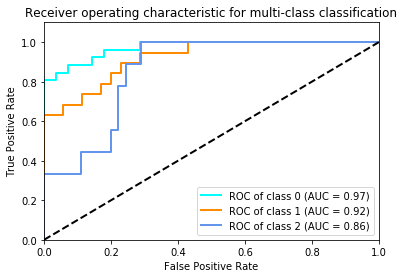

In [15]:
calc_plot_roc(X_test, y_test, y_pred, classes=classes)